In [1]:
import cv2
import numpy as np
import os.path as path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from matplotlib import rcParams
rcParams['figure.figsize'] = (13, 5)


In [2]:
class PipelineStage:
    def __init__(self, next_stage=None):
        self.next = next_stage
        
    def invoke_next(self, intermediate):
        if (self.next):
            return self.next(intermediate)
        else:
            return intermediate
        
    def pass_to(self, next_stage):
        self.next = next_stage
        return next_stage
        
    def process(self, intermedate):
        return intermediate
    
    def __call__(self, intermediate):
        return self.invoke_next(self.process(intermediate))

def to_rgb(intermediate):
    layer = np.uint8(intermediate * 255)
    return np.dstack((layer, layer, layer))

def visualize_process_stage(orig_img, processed_img, 
                            orig_title='Original image', 
                            processed_title='Processed Image', 
                            orig_cmap=None,
                            processed_cmap=None,
                            output_file=None):
    fig, axes = plt.subplots(1, 2)

    axes[0].imshow(orig_img, orig_cmap)
    axes[0].set_title(orig_title)

    axes[1].imshow(processed_img, processed_cmap)
    axes[1].set_title(processed_title)

    if (output_file):
        fig.savefig(output_file);
        
def make_output_path(input_path):
    basename = path.basename(input_path)
    return path.join('output_images', basename)


# Camera calibration

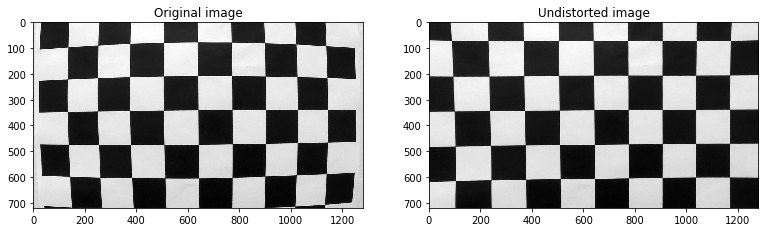

In [3]:
from glob import glob

def calibration_images():
    calibration_image_files = glob('camera_cal/calibration*.jpg')
    for fn in calibration_image_files:
        img = mpimg.imread(fn)
        yield cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def find_chessboard_corners(images):
    board_size = (9, 6)
    obj_corners = np.array([[x, y, 0] for y in range(board_size[1]) 
                            for x in range(board_size[0])],
                          dtype=np.float32)

    obj_points = []
    image_points = []
    for img in calibration_images():
        ret, corners = cv2.findChessboardCorners(img, board_size, None)
        if ret: 
            obj_points.append(obj_corners)
            image_points.append(corners)
    
    return (obj_points, image_points)

def calibrate_camera(obj_points, image_points):
    calibration_image_size = (720, 1280)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        obj_points, image_points, calibration_image_size, None, None)
        
    if ret: 
        return (mtx, dist)
    else:
        raise "Unable to calibrate camera"
        
class CorrectDistortion(PipelineStage):
    mtx = None
    dist = None
    
    @classmethod
    def calibrate(self, calibration_images):
        obj_points, image_points = find_chessboard_corners(calibration_images)
        mtx, dist = calibrate_camera(obj_points, image_points)
        self.mtx = mtx
        self.dist = dist
    
    def process(self, image):
        return cv2.undistort(image, self.mtx, self.dist, None, self.mtx)

        
    
CorrectDistortion.calibrate(calibration_images())

test_image = next(calibration_images())
processor = CorrectDistortion()
visualize_process_stage(test_image, processor(test_image), 
                        processed_title='Undistorted image',
                        orig_cmap='gray', processed_cmap='gray',
                        output_file='output_images/calibration_test.png')


# Image processing pipeline

In [4]:
sample_image = mpimg.imread('./test_images/test2.jpg')

## Correcting distortion

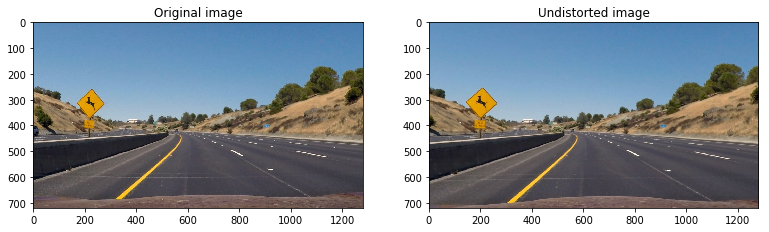

In [5]:
corrector = CorrectDistortion()
processed_image = corrector(sample_image)

visualize_process_stage(sample_image, processed_image, 
                        processed_title='Undistorted image', 
                        output_file='output_images/undistorted.png')

## Thresholding

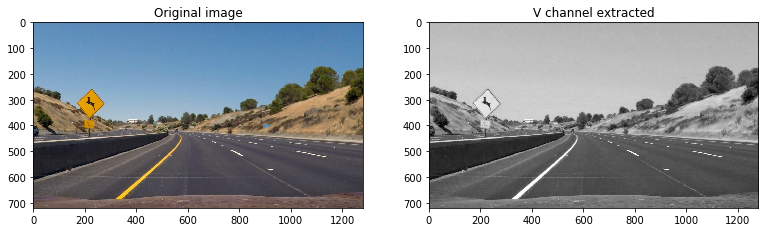

In [6]:
class ExtractChannel(PipelineStage):
    def process(self, image):
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        return hsv[:, :, 2]
    
visualize_process_stage(sample_image, ExtractChannel()(sample_image), 
                       processed_title="V channel extracted", 
                       processed_cmap='gray',
                       output_file='output_images/v_channel.png')

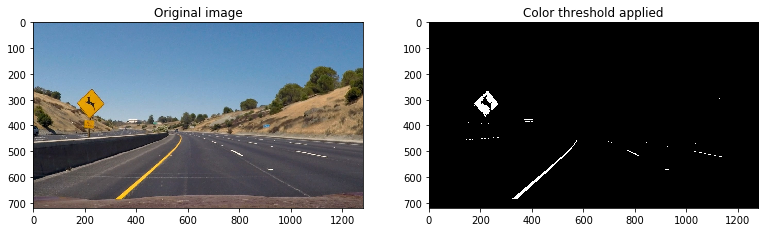

In [7]:
class ValueThreshold(PipelineStage):
    threshold = (220, 255)
    
    def process(self, image):
        mask = np.zeros_like(image)
        mask[(image > self.threshold[0]) & (image <= self.threshold[1])] = 1
        return mask
        

value_threshold = ExtractChannel(ValueThreshold())

processed = value_threshold(sample_image)
visualize_process_stage(sample_image, processed,
                        processed_title='Color threshold applied', 
                        processed_cmap='gray',
                        output_file='output_images/color_threshold.png')




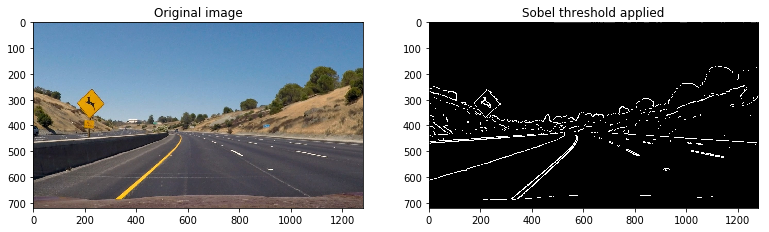

In [8]:
class SobelMagnitudeThreshold(PipelineStage):
    threshold = (80, 255)
    kernel = 5
    
    def process(self, image):
        blur = cv2.GaussianBlur(image, (5, 5), 0)
        sobel_x = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=self.kernel)
        sobel_y = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=self.kernel)
        sobel_mag = np.sqrt(np.square(sobel_x) + np.square(sobel_y))
        sobel_scaled = np.uint8(255 * sobel_mag / np.max(sobel_mag))
        mask = np.zeros_like(sobel_scaled)
        
        mask[(sobel_scaled > self.threshold[0]) & (sobel_scaled <= self.threshold[1])] = 1
        return mask
        

sobel_mag = ExtractChannel(SobelMagnitudeThreshold())
visualize_process_stage(sample_image, sobel_mag(sample_image),
                        processed_title='Sobel threshold applied', 
                        processed_cmap='gray',
                        output_file='output_images/sobel_threshold.png')

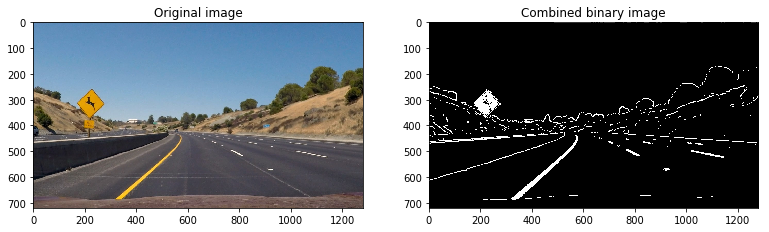

In [9]:
class Or(PipelineStage):
    def __init__(self, t1, t2, next_stage=None):
        super().__init__(next_stage)
        self.t1 = t1
        self.t2 = t2
        
    def process(self, image):
        m1 = self.t1(image)
        m2 = self.t2(image)
        
        mask = np.zeros(image.shape[0:2])
        mask[(m1 == 1) | (m2 == 1)] = 1
        return mask
    
stage = ExtractChannel(Or(ValueThreshold(), SobelMagnitudeThreshold()))

visualize_process_stage(sample_image, stage(sample_image),
                        processed_title='Combined binary image', 
                        processed_cmap='gray',
                        output_file='output_images/combined_threshold.png')

## Perspective transform

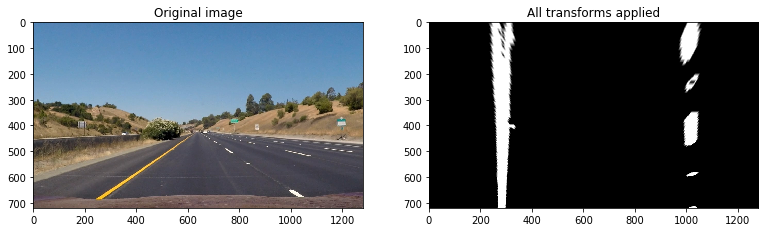

In [10]:
class PerspectiveTransform(PipelineStage):
    image_points = np.array([(281, 668), (582, 460), (703, 460), (1023, 668)], dtype=np.float32)
    object_points = np.array([(281, 720), (281, 0), (1023, 0), (1023, 720)], dtype=np.float32)
    warp_mtx = cv2.getPerspectiveTransform(image_points, object_points)
    unwarp_mtx = cv2.getPerspectiveTransform(object_points, image_points)
    
    def apply(self, image, mtx):
        img_size = (image.shape[1], image.shape[0])
        warped = cv2.warpPerspective(image, mtx, img_size, flags=cv2.INTER_LINEAR)
        return warped
    
class UnwarpPerspective(PerspectiveTransform):
    def process(self, image):
        return self.apply(image, self.warp_mtx)
    
class WarpPerspective(PerspectiveTransform):
    def process(self, image):
        return self.apply(image, self.unwarp_mtx)

transform = CorrectDistortion(
        ExtractChannel(
            Or(ValueThreshold(), SobelMagnitudeThreshold(),
              UnwarpPerspective())))

perspect_image = mpimg.imread('./test_images/straight_lines1.jpg')
warped = transform(perspect_image)
visualize_process_stage(perspect_image, warped, processed_title='All transforms applied', 
                        output_file='output_images/perspective_transform_thresh.png',
                        processed_cmap='gray')


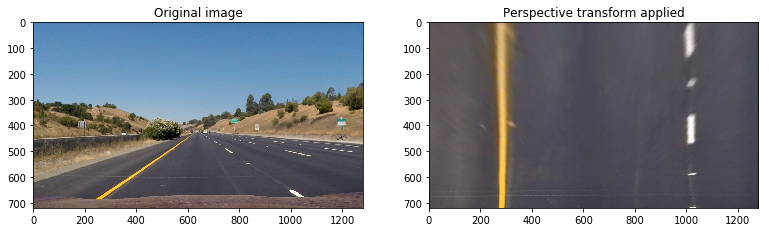

In [11]:
transform = CorrectDistortion(UnwarpPerspective())

warped = transform(perspect_image)
visualize_process_stage(perspect_image, warped, processed_title='Perspective transform applied', 
                        output_file='output_images/perspective_transform.png')


## Finding lane lines

## Convolutional approach

In [12]:
from collections import deque

def approximator(points, scale_x, scale_y):
    poly = np.poly1d(np.polyfit(points[:, 1] * scale_y, points[:, 0] * scale_x, 2))
    return poly

class LaneTracker:
    def __init__(self):
        self.left = deque(maxlen=90)
        self.right = deque(maxlen=90)
        self.mid = deque(maxlen=180)

        self.width = 0
        
    def set_width(self, value):
        self.width = value
        
    def append_left(self, x, y):
        self.left.append((x, y))
        self.mid.append(((x + self.width // 2), y))
        
    def append_right(self, x, y):
        self.right.append((x, y))
        self.mid.append(((x - self.width // 2), y))
        
    def mid_approx(self, scale_x=1, scale_y=1):
        return approximator(np.array(self.mid), scale_x, scale_y)
                            
    
class Convolver:
    window_width = 50
    window_height = 80
    margin = 100
    window = np.ones(window_width)
    
    def __init__(self, image, lane):
        self.image = image
        self.lane = lane

        self.image_width = image.shape[1]
        self.image_height = image.shape[0]
        self.prev = self.find_initial_centroids()
        self.lane.set_width(self.prev[1] - self.prev[0])
        
    def find_initial_centroids(self):
        lower_bound = self.image_height
        upper_bound = int(self.image_height / 2)
        pixels = self.image[upper_bound:lower_bound, :]
        pixel_sum = np.sum(pixels, axis=0)
        conv_signal = np.convolve(pixel_sum, self.window)    
        
        middle = len(conv_signal) // 2
        left_peak = np.argmax(conv_signal[:middle]) - self.window_width // 2
        right_peak = np.argmax(conv_signal[middle:]) + middle - self.window_width // 2
        return [left_peak, right_peak]
    
    def convolve_by_layer(self):
        layers = int(self.image_height / self.window_height)
        for layer in range(layers):
            lower_bound = self.image_height - (layer + 1) * self.window_height
            upper_bound = self.image_height - layer * self.window_height
            layer_sum = np.sum(self.image[lower_bound:upper_bound, :], axis=0)
            conv_signal = np.convolve(layer_sum, self.window)
            y = (lower_bound + upper_bound) // 2
            yield (y, conv_signal)
            
    def find_centroid(self, midpoint, signal):
        left = max(0, midpoint - self.margin)
        right = min(midpoint + self.margin, len(signal))
        search_area = signal[left:right]
        if (np.std(search_area) == 0):
            return None
        else:
            centroid = np.argmax(search_area) + left - self.window_width // 2
            return centroid
    
    def find_centroids(self):
        for y, signal in self.convolve_by_layer():
            left = self.find_centroid(self.prev[0], signal)
            right = self.find_centroid(self.prev[1], signal)
            
            if left:
                self.lane.append_left(left, y)
                self.prev[0] = left
                
            if right:
                self.lane.append_right(right, y)
                self.prev[1] = right
                
    
class FindLinePoints(PipelineStage):
    def __init__(self, next_stage=None):
        super().__init__(next_stage)
        self.lane = LaneTracker()
        
    def process(self, image):
        conv = Convolver(image, self.lane)
        conv.find_centroids()
        return self.lane

class VisualizeLane(PipelineStage):
    image_shape = (720, 1280)
    ym_per_pix = 3.0/72 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    
    def process(self, lane):
        image = np.zeros(self.image_shape + (3,), dtype=np.uint8)
        
        self.plot_approx(lane, image)
        self.plot_points(lane.left, image, (255, 0, 0))
        self.plot_points(lane.right, image, (0, 0, 255))
        
        return (image, self.curvature(lane), self.off_center(lane))
    
    def curvature(self, lane):
        approx = lane.mid_approx(self.xm_per_pix, self.ym_per_pix)
        a, b = approx.c[0:2]
        return ((1 + (2* a * self.image_shape[0] * self.ym_per_pix + b)**2)**1.5) / np.absolute(2 * a)
    
    def off_center(self, lane):
        approx = lane.mid_approx()
        x = approx(self.image_shape[0])
        return (self.image_shape[1] / 2 - x) * self.xm_per_pix
    
    def plot_points(self, points, image, color):
        for pt in points:
            cv2.circle(image, pt, 10, color, -1)

    def plot_approx(self, lane, image):
        ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
        midline = lane.mid_approx()(ploty)
        left_bound_x = midline - lane.width / 2
        right_bound_x = midline + lane.width / 2
        
        left_bound = np.array([np.vstack((left_bound_x, ploty)).T])
        right_bound = np.array([np.flipud(np.vstack((right_bound_x, ploty)).T)])
        bound = np.hstack((left_bound, right_bound))
        
        cv2.fillPoly(image, np.int_([bound]), (0, 255, 0))

# Video processing pipeline

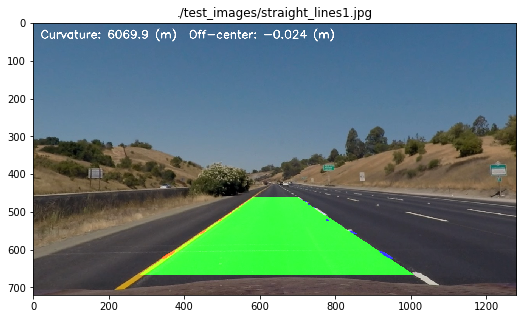

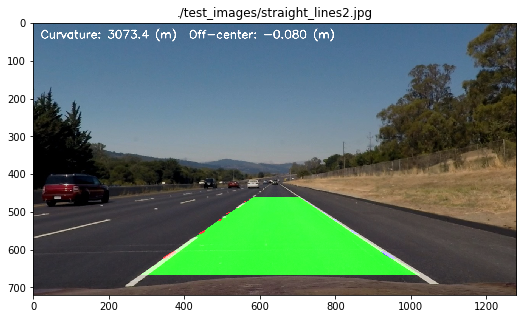

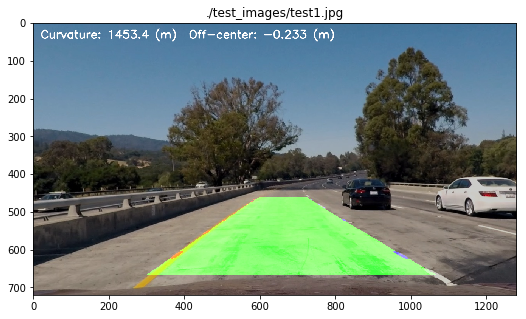

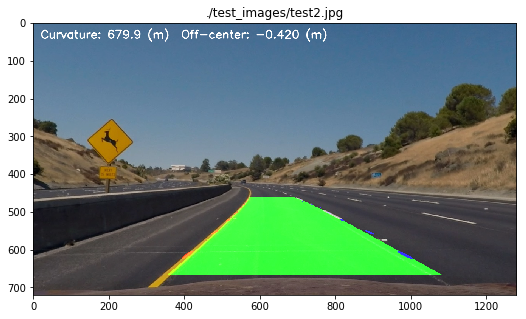

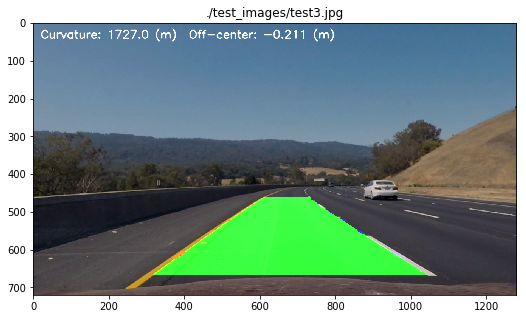

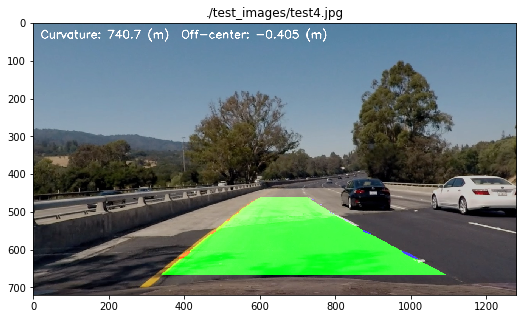

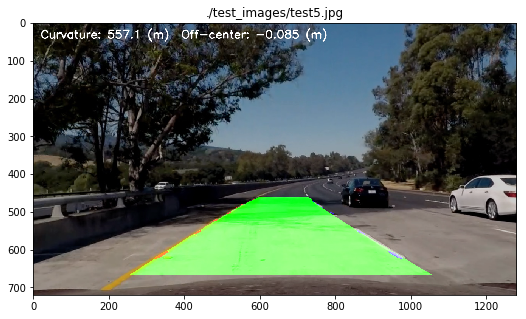

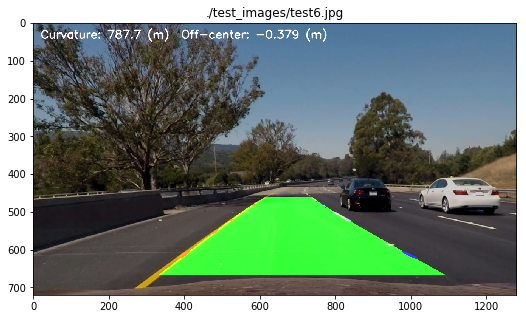

In [13]:
import os.path as path
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def display_video(video_file):
    return HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_file))

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def process_video(filename, processor):
    clip = VideoFileClip(filename)
    processed = clip.fl_image(processor)
    
    output_file = make_output_path(filename)
    processed.write_videofile(output_file, audio=False)
    return output_file

def put_text(image, text):
    cv2.putText(image, text,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

def process_frame(line_detector):
    undistort = CorrectDistortion()
    warp = WarpPerspective()
    
    def _fn(video_frame):
        try:
            undist = undistort(video_frame)
            lines_img, curv, off_center = line_detector(undist)
            combined_image = weighted_img(warp(lines_img), undist)
            put_text(combined_image, "Curvature: %.1f (m)  Off-center: %.3f (m)" % (curv, off_center))
            return combined_image
        except Exception as ex:
            raise Exception('Got an exception', video_frame, ex)
    
    return _fn

def line_detector():
    return process_frame(
    ExtractChannel(
        Or(SobelMagnitudeThreshold(), ValueThreshold(), 
              UnwarpPerspective(
                    FindLinePoints(VisualizeLane())))))


for test_image_file in glob('./test_images/*.jpg'):
    sample_image = plt.imread(test_image_file)
    plt.figure()
    plt.imshow(line_detector()(sample_image))
    plt.title(test_image_file)
    plt.savefig(make_output_path(test_image_file))

In [14]:
input_file = './project_video.mp4'
output = process_video(input_file, line_detector())

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [02:12<00:00,  9.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 



In [15]:
display_video(output)